# Data Analysis of Training Data

This notebook analyzes the **Don't Patronize Me! dataset**, specifically focusing on:
- Class distribution (PCL vs. Non-PCL)
- Text length analysis
- Category-wise analysis

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis (EDA)

In [2]:
column_names = ["ID", "ParagraphID", "Category", "CountryCode", "Text", "Label"]
pcl_df = pd.read_csv("dontpatronizeme_pcl.tsv", sep='\t', names=column_names, skiprows=10)
train_labels = pd.read_csv("train_semeval_parids-labels.csv")

In [3]:
pcl_df.head()

,ID,ParagraphID,Category,CountryCode,Text,Label
0,7,@@7562079,refugee,za,The European Union is making an historic mista...,0
1,8,@@23663488,hopeless,nz,""" They 're either hopeless for being beaten by...",0
2,9,@@3449225,homeless,ph,"NUEVA ERA , Ilocos Norte - No family shall be ...",1
3,10,@@2485090,in-need,nz,His spokesman said the Kremlin needed more inf...,0
4,11,@@21290047,migrant,in,A federal appeals court on Tuesday cleared the...,0


In [4]:
train_labels.head()

,par_id,label
0,4341,"[1, 0, 0, 1, 0, 0, 0]"
1,4136,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,"[1, 0, 0, 1, 1, 1, 0]"


In [5]:
# Rename ID column for merging
pcl_df.rename(columns={"ID": "par_id"}, inplace=True)

# Merge training labels with main text dataset
train_df = train_labels.merge(pcl_df, on="par_id", how="left")

# Keep only relevant columns
train_df = train_df[["par_id", "Text", "Label"]]

train_df.head()

,par_id,Text,Label
0,4341,"The scheme saw an estimated 150,000 children f...",4.0
1,4136,Durban 's homeless communities reconciliation ...,2.0
2,10352,The next immediate problem that cropped up was...,4.0
3,8279,Far more important than the implications for t...,2.0
4,1164,To strengthen child-sensitive social protectio...,4.0


### Analysis of Class Distribution

/tmp/ipykernel_875353/3543582610.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="coolwarm")


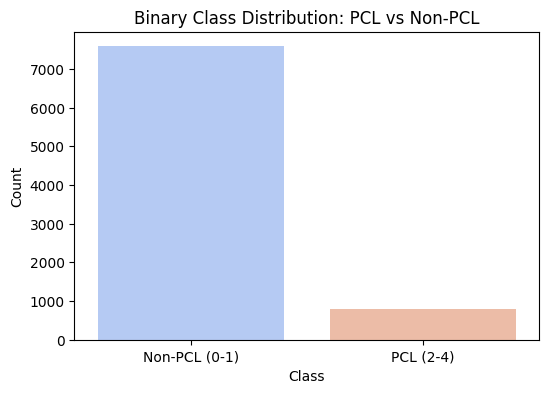

In [6]:
# Group labels (0-1 = Non-PCL, 2-4 = PCL)
train_df["Binary_Label"] = train_df["Label"].apply(lambda x: 1 if x >= 2 else 0)

# Count occurrences
label_counts = train_df["Binary_Label"].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="coolwarm")
plt.xticks([0, 1], ["Non-PCL (0-1)", "PCL (2-4)"])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Binary Class Distribution: PCL vs Non-PCL")
plt.show()

- The dataset is highly **imbalanced**, with way more Non-PCL examples than PCL.
- This imbalance could impact the ability of the model to learn patronizing language.
- Solutions: **Resampling strategies** (oversampling PCL cases) or **class weighting**.

### Analysis of PCL Distribution by Category

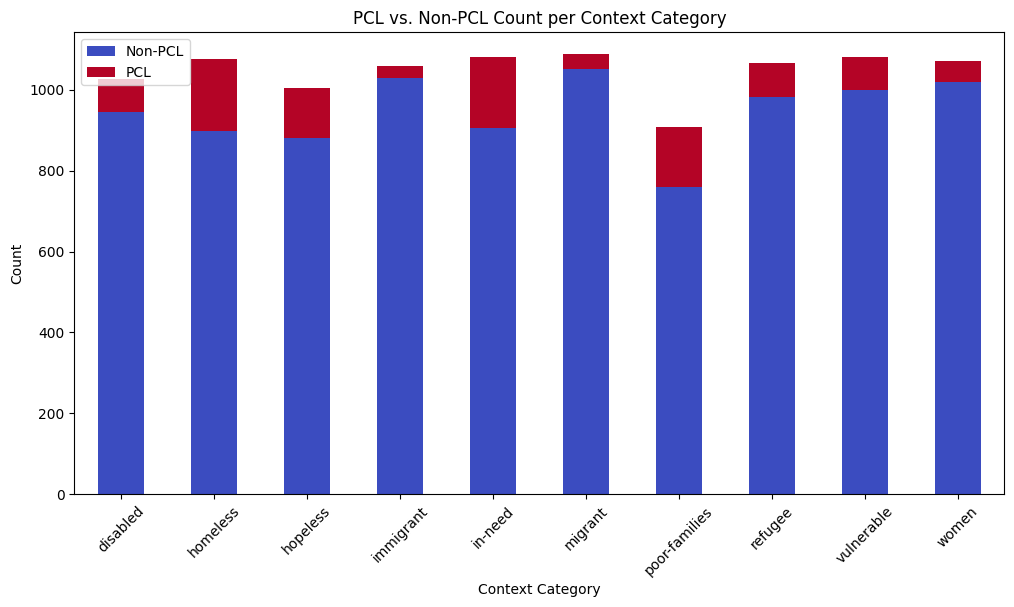

In [7]:
# Create a binary column: Non-PCL (0-1) vs. PCL (2-4)
pcl_df["Binary_Label"] = pcl_df["Label"].apply(lambda x: "Non-PCL" if x <= 1 else "PCL")

# Count occurrences of each category for PCL and Non-PCL
category_counts = pcl_df.groupby("Category")["Binary_Label"].value_counts().unstack()

# Plot as a stacked bar chart
category_counts.plot(kind="bar", stacked=True, figsize=(12,6), colormap="coolwarm")

# Labels and title
plt.xlabel("Context Category")
plt.ylabel("Count")
plt.title("PCL vs. Non-PCL Count per Context Category")
plt.xticks(rotation=45)
plt.legend(["Non-PCL", "PCL"])
plt.show()

Some topics like **homelessness** or **in-need** have more PCL cases, while a few categories rarely contain patronizing language, especially **immigrant** / **migrant**. This suggests **topic-based biases** in the dataset.

### Analysis of Text Lengths
Does text length correlate with PCL?

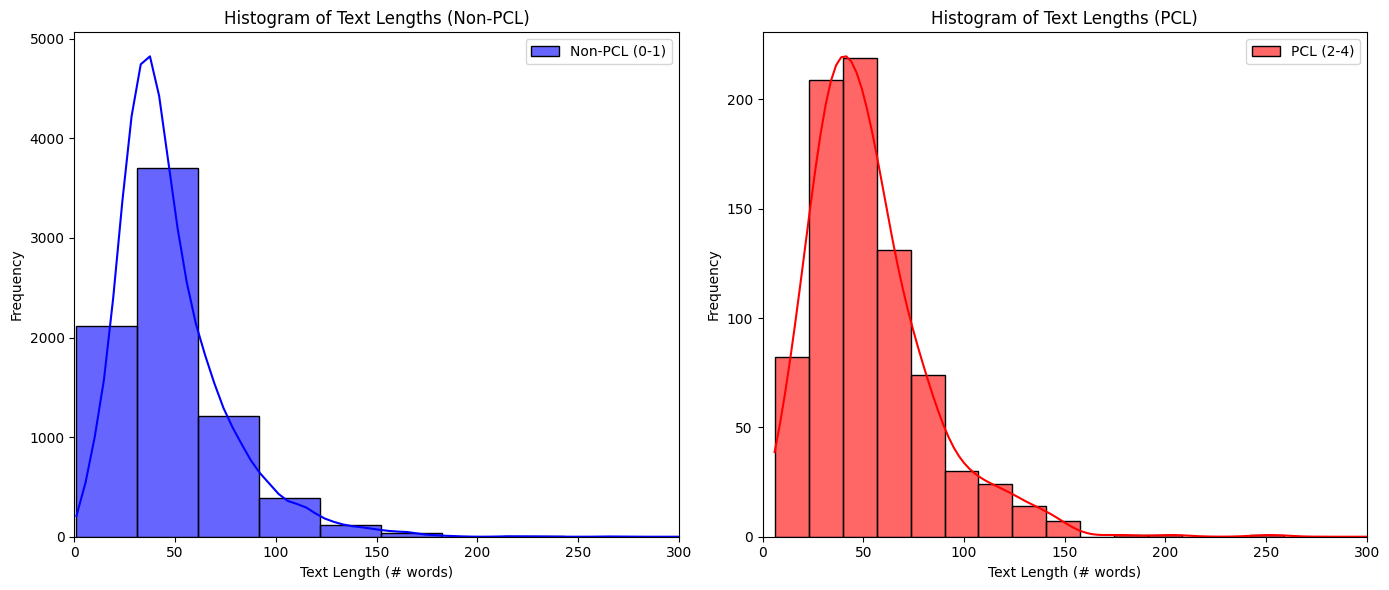

In [8]:
# Compute text lengths
train_df["Text_Length"] = train_df["Text"].astype(str).apply(lambda x: len(x.split()))

# Define colors for the two classes
colors = ["blue", "red"]

# Create subplots (1 row, 2 columns) with different scales
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Non-PCL Histogram
sns.histplot(train_df[train_df["Binary_Label"] == 0]["Text_Length"], 
             bins=30, color=colors[0], kde=True, label="Non-PCL (0-1)", alpha=0.6, ax=axes[0])
axes[0].set_xlabel("Text Length (# words)")
axes[0].set_xlim(0, 300)
axes[0].set_ylabel("Frequency")
axes[0].set_title("Histogram of Text Lengths (Non-PCL)")
axes[0].legend()

# PCL Histogram
sns.histplot(train_df[train_df["Binary_Label"] == 1]["Text_Length"], 
             bins=30, color=colors[1], kde=True, label="PCL (2-4)", alpha=0.6, ax=axes[1])
axes[1].set_xlabel("Text Length (# words)")
axes[1].set_xlim(0, 300)
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of Text Lengths (PCL)")
axes[1].legend()

# Adjust layout
plt.tight_layout()

plt.show()

Both PCL and Non-PCL samples tend to have less than 200 words, with most of the texts having around 50 words and some outliers with extremely long sentences. Overall, we cannot infer that the length of the sample has an influence towards either of the labels, as the distributions are fairly similar.

### Patronizing Language Types Analysis
We now examine how PCL is expressed (e.g. Authority Voice, Compassion).


In [9]:
# Load the PCL categories dataset
category_columns = [
    "par_id", "ParagraphID", "Text", "Category", "CountryCode", 
    "Start_Char", "End_Char", "Annotated_Text", "PCL_Type", "Label"
]
categories_df = pd.read_csv("dontpatronizeme_categories.tsv", sep='\t', names=category_columns, skiprows=10)

In [10]:
categories_df.head()

,par_id,ParagraphID,Text,Category,CountryCode,Start_Char,End_Char,Annotated_Text,PCL_Type,Label
0,1279,@@7896098,Pope Francis washed and kissed the feet of Mus...,refugee,ng,13,158,"washed and kissed the feet of Muslim , Orthodo...",Shallow_solution,2
1,8330,@@17252299,Many refugees do n't want to be resettled anyw...,refugee,ng,0,73,Many refugees do n't want to be resettled anyw...,Presupposition,2
2,4063,@@3002894,"Budding chefs , like "" Fred "" , "" Winston "" an...",in-need,ie,122,160,desperately in need of a helping hand,Compassion,2
3,4063,@@3002894,"Budding chefs , like "" Fred "" , "" Winston "" an...",in-need,ie,145,160,a helping hand,Metaphors,1
4,4063,@@3002894,"Budding chefs , like "" Fred "" , "" Winston "" an...",in-need,ie,145,209,a helping hand to enable them to re-build thei...,Unbalanced_power_relations,1


/tmp/ipykernel_875353/2467944143.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pcl_type_counts.index, y=pcl_type_counts.values, palette="coolwarm")


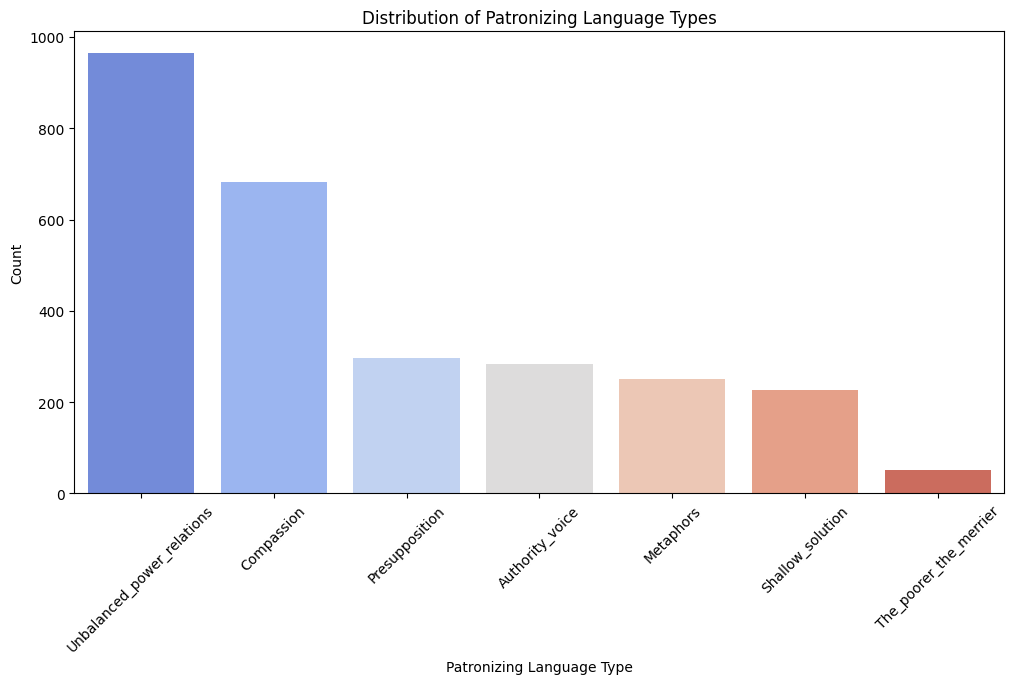

In [11]:
# Count occurrences of each PCL_Type
pcl_type_counts = categories_df["PCL_Type"].value_counts()

# Plot the category distribution
plt.figure(figsize=(12,6))
sns.barplot(x=pcl_type_counts.index, y=pcl_type_counts.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Patronizing Language Type")
plt.ylabel("Count")
plt.title("Distribution of Patronizing Language Types")
plt.show()

Some PCL types (e.g. **Unbalanced Power Relations, Compassion**) dominate, while others (e.g. **Metaphors, The Poorer The Merrier**) occur less frequently. This impacts model performance: **More common PCL types are easier to detect.**